In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import anndata 
from scipy.stats import fisher_exact
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.pyplot import rc_context

In [2]:
base_dir = '//wynton//protected//home//ichs//tzack//FLC//Hyperammonemia//'
flc_dir = '//wynton//protected//home//ichs//tzack//FLC//'

In [3]:
df = pd.read_csv(base_dir+"labs_for_enc_with_max_ammonia_02032022.csv")

In [4]:
len(df)

16333

In [5]:
len(list(set(df['PatientDurableKey'])))

12719

In [6]:
df = pd.read_csv(base_dir+"labs_for_enc_with_max_ammonia_02032022.csv")
df = df.drop('Unnamed: 0',axis=1)
#count number of nans in each row
nans_per_row = df.isnull().sum(axis=1)

df = df.drop(['Total_protein','PTT','PT','Fib'],axis=1)
df = df.drop_duplicates()

#selecting out hyperammonemia
df = df.loc[df['Ammonia']>=50,:].reset_index(drop=True)

HCC_df = pd.read_csv(flc_dir+"HCC_Binary_file_pt_exclusions_any_time_in_pt_history_new.csv")

#rounding age to nearest year (ish)
#age_at_dx = [0]*len(HCC_df)
#for i in range(len(age_at_dx)):
#    age_at_dx[i] = round(HCC_df.loc[i,'days_old_at_dx']/365)
##add this new column onto the original dataframe
#HCC_df['age_at_dx'] = age_at_dx
Dx_col = ['Not_HCC']*len(df)

#selecting out FLC patients
HCC_df['Dx'] = 'HCC'
#w.loc[w.female != 'female', 'female'] = 0
HCC_df.loc[HCC_df['FLC_dx']==1,'Dx'] = 'FLC'
df.insert(3, 'Dx', Dx_col)
FLC_pt = HCC_df.loc[HCC_df['Dx']=='FLC','Pt_ID'].tolist()
HCC_pt = HCC_df.loc[HCC_df['Dx']=='HCC','Pt_ID'].tolist()
df.loc[df['PatientDurableKey'].isin(FLC_pt),'Dx'] = 'FLC'
df.loc[df['PatientDurableKey'].isin(HCC_pt),'Dx'] = 'HCC'
#removing all nans
colnames = ['AST', 'ALT', 'Alk_phos', 'TBili', 'Ammonia','Na', 'K', 'Cl', 'CO2', 'BUN', 'Cr']
df_data = df.dropna(axis=0,subset = colnames,how='any').reset_index(drop=True)
df_labs_idx = ['EncounterKey']+colnames
df_labs = df_data.loc[:,df_labs_idx]
df_data['Dx1'] = df_data['Dx'].tolist()
df_data.loc[df_data['Dx1']=='HCC','Dx1'] = 'yHCC'
df_data.loc[df_data['Dx1']=='FLC','Dx1'] = 'zFLC'

In [9]:
#Z-score data (and shift to be all positive)
#for i in colnames:
#    data_cur = df_labs.loc[:,i]
#    mean_cur = np.mean(data_cur)
#    sd_cur = np.std(data_cur)
#    test = (data_cur-mean_cur)/sd_cur
#    df_labs.loc[:,i] = test

In [7]:
with open('df_metabolic_labs_hyperammonemia_nans_removed.csv') as your_data:
    adata = anndata.read_csv(your_data)

In [8]:
adata.obs["Dx"] = df_data['Dx1'].tolist()
colnames1 = list()
for i in colnames:
    colname_raw_cur = i+'_raw'
    colnames1.append(colname_raw_cur)
    adata.obs[colname_raw_cur] = df_labs[i].tolist()

In [9]:
#sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

In [10]:
sc.tl.pca(adata, svd_solver='arpack')

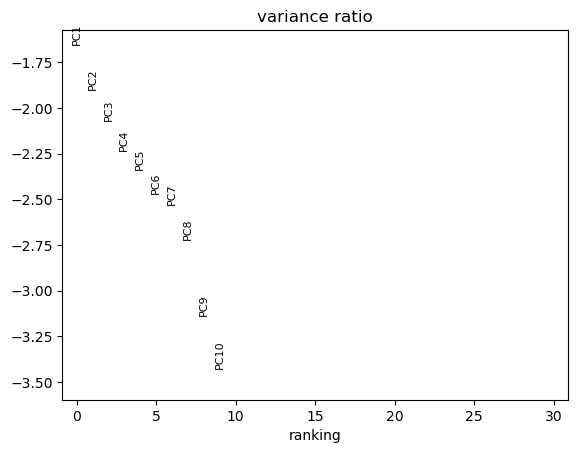

In [11]:
sc.pl.pca_variance_ratio(adata, log=True)

In [12]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=40,metric='minkowski')

In [13]:
sc.tl.umap(adata,min_dist=0.15)


In [14]:
import leidenalg

In [15]:
sc.tl.leiden(adata,resolution = 0.20)

In [16]:
new_cluster_names = ['1','2','3','4','5','6','7','8']
adata.rename_categories('leiden', new_cluster_names)

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [24]:
#for each lab value, get the mean and SD for each cluster
df_means = pd.DataFrame(index=new_cluster_names,columns=colnames)
df_median = pd.DataFrame(index=new_cluster_names,columns=colnames)
df_stds = pd.DataFrame(index=new_cluster_names,columns=colnames)
colnames = ['AST', 'ALT', 'Alk_phos', 'TBili', 'Ammonia','Na', 'K', 'Cl', 'CO2', 'BUN', 'Cr']
for l_cur in new_cluster_names:
    for c in colnames:
        cur_lab = np.array(df_labs.loc[(adata.obs['leiden']==l_cur).tolist(),c].tolist())
        df_means.loc[l_cur,c] = np.mean(cur_lab)
        df_median.loc[l_cur,c] = np.median(cur_lab)
        df_stds.loc[l_cur,c] = np.std(cur_lab)

In [26]:
df_median.to_csv('median_lab_value_by_cluster.csv')
df_means.to_csv('mean_lab_value_by_cluster.csv')
df_stds.to_csv('st_dev_lab_value_by_cluster.csv')

In [27]:
df_means

,AST,ALT,Alk_phos,TBili,Ammonia,Na,K,Cl,CO2,BUN,Cr
1,93.553279,61.45082,162.25,2.288012,72.377049,139.252049,4.155943,107.946721,21.502049,13.609631,0.715441
2,100.702259,67.661191,121.453799,2.042382,68.63039,138.004107,4.023203,101.38809,28.367556,19.319507,0.904251
3,143.624473,90.64557,150.767932,3.664451,79.424051,131.632911,4.007173,101.061181,21.316456,16.734599,0.900274
4,232.04698,158.595078,159.608501,3.327763,86.04698,135.565996,4.399553,103.684564,20.044743,54.345414,2.952013
5,311.201493,179.585821,674.910448,7.784627,70.541045,134.895522,4.129851,97.843284,21.955224,19.767537,0.923321
6,166.653061,119.52551,168.260204,23.427908,79.19898,135.137755,3.786735,102.637755,22.096939,27.462755,1.449745
7,204.25,133.05,168.383333,3.36125,211.8,139.141667,3.938333,106.616667,22.525,16.311667,1.0485
8,4136.459184,3044.540816,140.5,5.04898,87.112245,137.877551,3.918367,104.959184,22.030612,19.776531,1.437959


In [20]:
adata_HCC = adata[adata.obs['Dx']!='Not_HCC',:]
adata_FLC = adata[adata.obs['Dx']=='zFLC',:]

In [21]:
#### THIS WILL ZSCORE DATA be CAREFUL sc.pp.scale(adata, max_value=100)

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Dx' as categorical


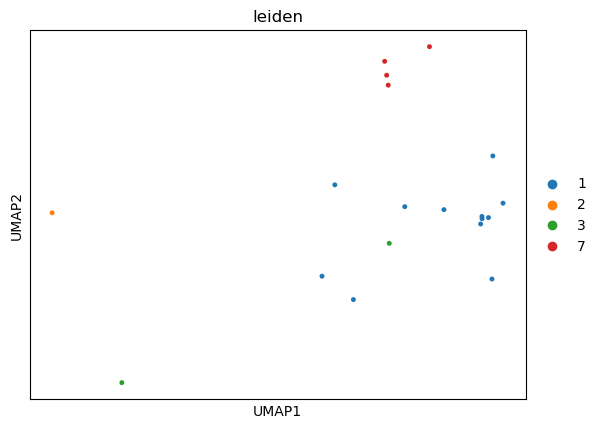

In [22]:
sc.pl.umap(adata_FLC, color=['leiden'],size=50,save='Metabolic_labs_hyperammonemia_FLC_only_umap_color_by_leiden.pdf')

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Dx' as categorical


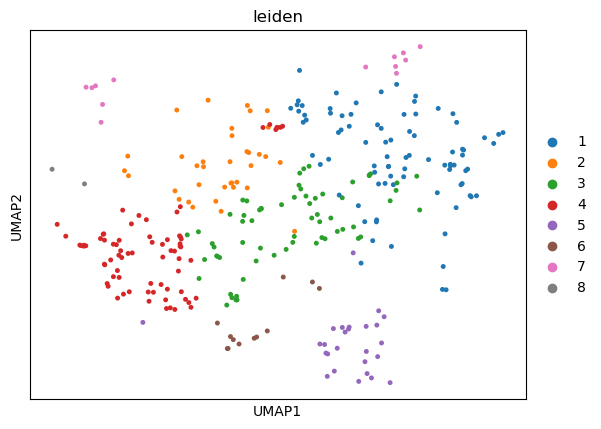

In [23]:
sc.pl.umap(adata_HCC, color=['leiden'],size=50,save='Metabolic_labs_hyperammonemia_HCC_only_umap_color_by_leiden.pdf')

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Dx' as categorical


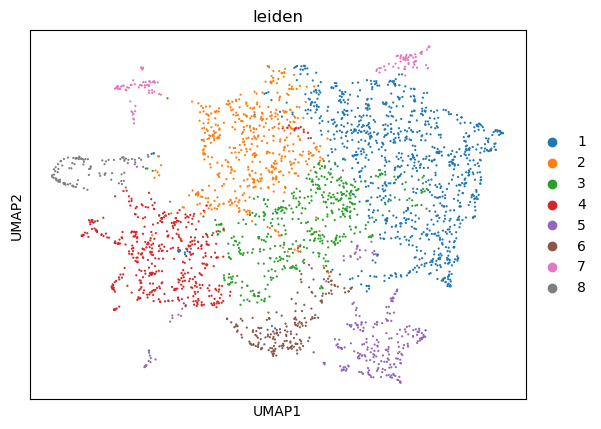

In [24]:
sc.pl.umap(adata, color=['leiden'],size=10,save='Metabolic_labs_hyperammonemia_umap_color_by_leiden_and_Dx.pdf')

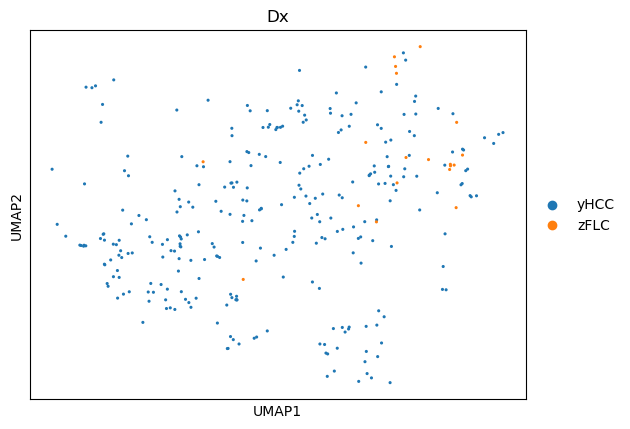

In [25]:
sc.pl.umap(adata_HCC, color=['Dx'],size=20,save='Metabolic_labs_hyperammonemia_umap_only_FLC_HCC.pdf')

#Create violin Plots

In [26]:
os.chdir('//wynton//protected//home//ichs//tzack//FLC//')
adata.uns['Dx_colors'] = ['green','yellow','red']

In [28]:
fig_fold = '//wynton//protected//home//ichs//tzack//FLC//Hyperammonemia//figures//'

In [29]:
df_other_dx = pd.read_csv(flc_dir+'Hyperammonemia/Other_Dx_file.csv')
df_other_dx.columns

Index(['Unnamed: 0', 'Pt_ID', 'CRC', 'PDAC', 'BREAST', 'TLS'], dtype='object')

In [30]:


def print_umap_by_dx(df_other_dx,df_data,adata,col_name,file_name):
    #CRC
    dx_pt = list(set(df_other_dx.loc[df_other_dx[col_name]==1,'Pt_ID']))
    dx_col = ['Not_'+col_name]*len(df_labs)
    s = 0
    for i in range(len(df_data)):
        if df_data.loc[i,'PatientDurableKey'] in dx_pt:
            s+=1
            dx_col[i] = col_name
    adata.obs[col_name] = dx_col
    adata_dx = adata[adata.obs[col_name]==col_name,:]
    sc.pl.umap(adata_dx, color=['leiden'],size=20,save=file_name)
    
    #calculating significance of each cluster for this Dx
    p_list = list()
    l_list = list(set(adata.obs['leiden']))
    l_list.sort()
    for l_cur in l_list:
        adata_cur = adata[adata.obs['leiden']==l_cur,:]
        tot_n,m = adata.shape
        l_cur_n,m = adata_cur.shape
        s = sum(adata.obs[col_name]==col_name)
        a = sum(adata_cur.obs[col_name]==col_name)
        b = s-a
        c = l_cur_n-a
        d = tot_n-a-b-c
        dx_fet_table = np.array([[a, b], [c, d]])
        oddsr, p_cur_l = fisher_exact(dx_fet_table, alternative='greater')
        p_list.append(min(8*p_cur_l,1))
    return p_list

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'CRC' as categorical


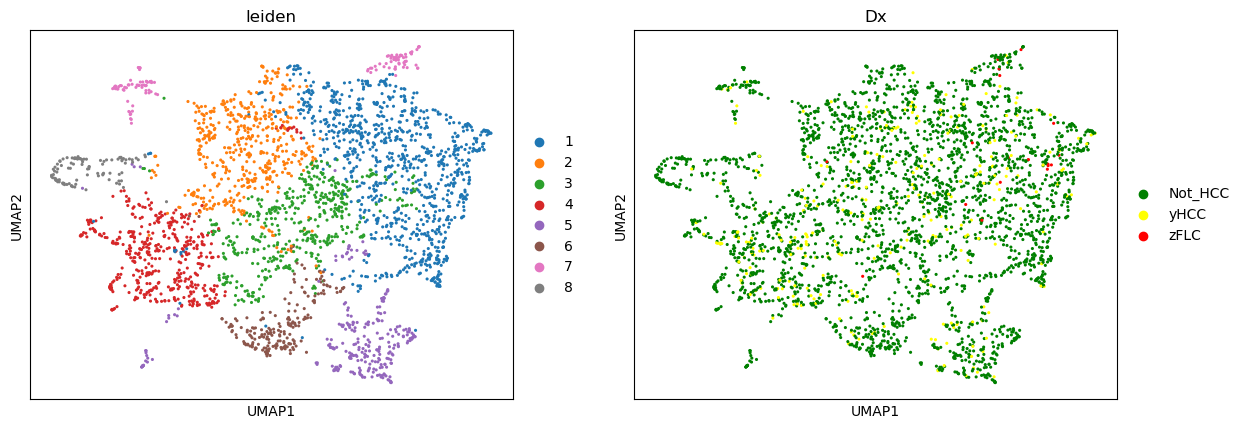

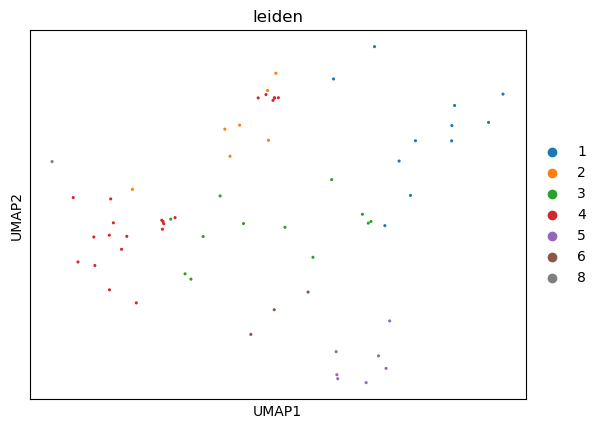

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'CRC' as categorical
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted

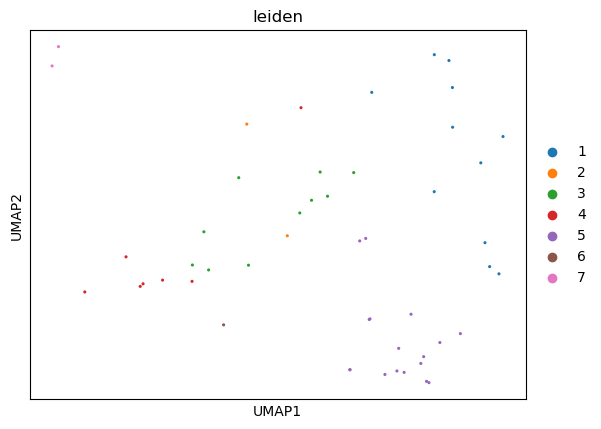

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'CRC' as categorical
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted

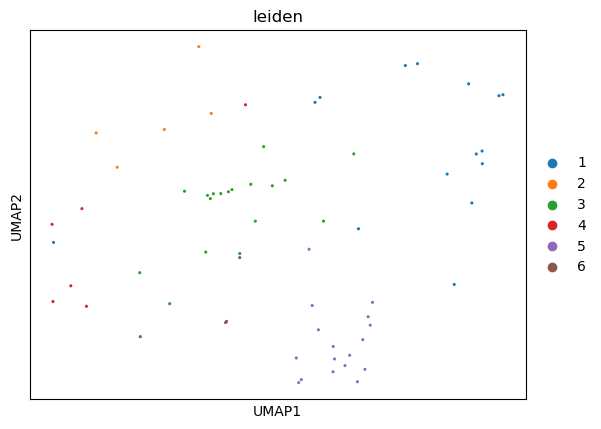

In [31]:
p_list_crc = print_umap_by_dx(df_other_dx,df_data,adata,'CRC','_crc_umap_colored_by_cluster.pdf')
p_list_pdac = print_umap_by_dx(df_other_dx,df_data,adata,'PDAC','_pdac_umap_colored_by_cluster.pdf')
p_list_breast = print_umap_by_dx(df_other_dx,df_data,adata,'BREAST','_breast_umap_colored_by_cluster.pdf')
#p_list_tls = print_umap_by_dx(df_other_dx,df_data,adata,'TLS','_tls_umap_colored_by_cluster.pdf')

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'CRC' as categorical
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted

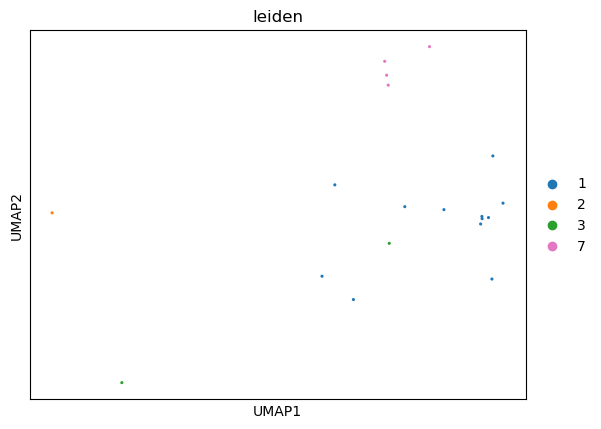

In [32]:
dx_col = ['not_FLC']*len(df_labs)
s = 0
for i in range(len(df_data)):
    if df_data.loc[i,'PatientDurableKey'] in FLC_pt:
        s+=1
        dx_col[i] = 'FLC'
adata.obs['FLC'] = dx_col
adata_dx = adata[adata.obs['FLC']=='FLC',:]
sc.pl.umap(adata_dx, color=['leiden'],size=20,save='_FLC_umap_colored_by_cluster.pdf')

#calculating significance of each cluster for this Dx
p_list_flc = list()
l_list = list(set(adata.obs['leiden']))
l_list.sort()
for l_cur in l_list:
    adata_cur = adata[adata.obs['leiden']==l_cur,:]
    tot_n,m = adata.shape
    l_cur_n,m = adata_cur.shape
    s = sum(adata.obs['FLC']=='FLC')
    a = sum(adata_cur.obs['FLC']=='FLC')
    b = s-a
    c = l_cur_n-a
    d = tot_n-a-b-c
    dx_fet_table = np.array([[a, b], [c, d]])
    oddsr, p_cur_l = fisher_exact(dx_fet_table, alternative='greater')
    p_list_flc.append(min(8*p_cur_l,1))

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'CRC' as categorical
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted

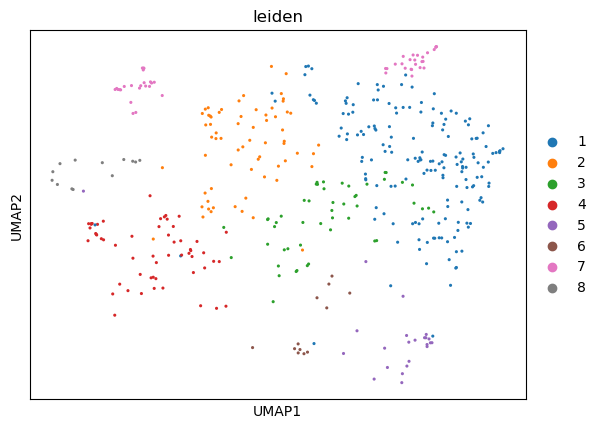

In [33]:
#Port in urea cycle patients to see how they are distributed
UCD_df = pd.read_csv(flc_dir+"Urea_cycle_disorder_diagnosis_EF_list.csv")
UCD_pt = list(set(UCD_df['PatientDurableKey'].tolist()))
UCD_col = ['Not_UCD']*len(df_labs)
s = 0
for i in range(len(df_data)):
    if df_data.loc[i,'PatientDurableKey'] in UCD_pt:
        s+=1
        UCD_col[i] = 'UCD'
adata.obs['UCD'] = UCD_col
adata_dx = adata[adata.obs['UCD']=='UCD',:]
sc.pl.umap(adata_dx, color=['leiden'],size=20,save='_UCD_umap_colored_by_cluster.pdf')

#calculating significance of each cluster for this Dx
p_list_ucd = list()
l_list = list(set(adata.obs['leiden']))
l_list.sort()
for l_cur in l_list:
    adata_cur = adata[adata.obs['leiden']==l_cur,:]
    tot_n,m = adata.shape
    l_cur_n,m = adata_cur.shape
    s = sum(adata.obs['UCD']=='UCD')
    a = sum(adata_cur.obs['UCD']=='UCD')
    b = s-a
    c = l_cur_n-a
    d = tot_n-a-b-c
    dx_fet_table = np.array([[a, b], [c, d]])
    oddsr, p_cur_l = fisher_exact(dx_fet_table, alternative='greater')
    p_list_ucd.append(min(8*p_cur_l,1))

/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'CRC' as categorical
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted

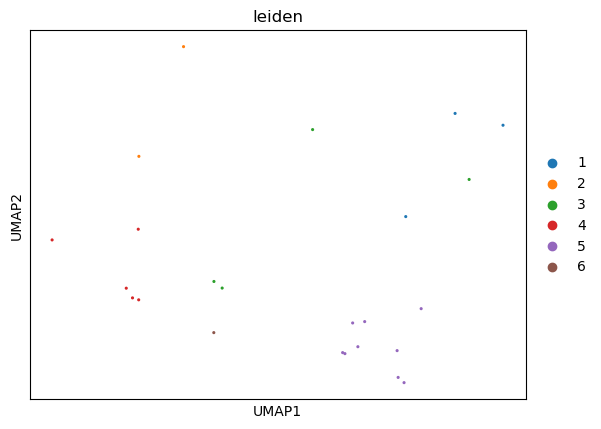

In [34]:
no_sclerosis_or_fibrosis = list(set(HCC_df.loc[((HCC_df['Fibrosis']==0) & (HCC_df['sclerosis']==0)),'Pt_ID']))
hcc_pt = list(set(HCC_df.loc[HCC_df['Dx']=='HCC','Pt_ID']))
hcc_no_cirrhosis = list(set(no_sclerosis_or_fibrosis).intersection(hcc_pt))
dx_col = ['HCC_Cirrhosis']*len(df_labs)
s = 0
for i in range(len(df_data)):
    if df_data.loc[i,'PatientDurableKey'] in hcc_no_cirrhosis:
        s+=1
        dx_col[i] = 'HCC_no_cirrhosis'
adata.obs['HCC_no_cirrhosis'] = dx_col
adata_dx = adata[adata.obs['HCC_no_cirrhosis']=='HCC_no_cirrhosis',:]
sc.pl.umap(adata_dx, color=['leiden'],size=20,save='_hcc_no_cirrhosis_umap_colored_by_cluster.pdf')

#calculating significance of each cluster for this Dx
p_list_hcc_no_cirrhosis = list()
l_list = list(set(adata.obs['leiden']))
l_list.sort()
for l_cur in l_list:
    adata_cur = adata[adata.obs['leiden']==l_cur,:]
    tot_n,m = adata.shape
    l_cur_n,m = adata_cur.shape
    s = sum(adata.obs['HCC_no_cirrhosis']=='HCC_no_cirrhosis')
    a = sum(adata_cur.obs['HCC_no_cirrhosis']=='HCC_no_cirrhosis')
    b = s-a
    c = l_cur_n-a
    d = tot_n-a-b-c
    dx_fet_table = np.array([[a, b], [c, d]])
    oddsr, p_cur_l = fisher_exact(dx_fet_table, alternative='greater')
    p_list_hcc_no_cirrhosis.append(min(8*p_cur_l,1))


/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'CRC' as categorical
/wynton/protected/home/ichs/tzack/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted

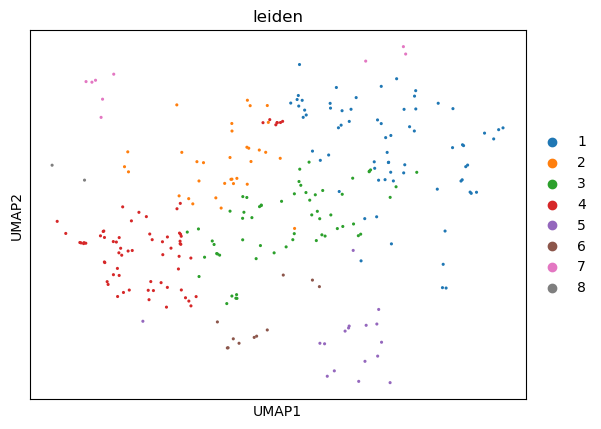

In [35]:
sclerosis_or_fibrosis = list(set(HCC_df.loc[((HCC_df['Fibrosis']==1) | (HCC_df['sclerosis']==1)),'Pt_ID']))
hcc_pt = list(set(HCC_df.loc[HCC_df['Dx']=='HCC','Pt_ID']))
hcc_cirrhosis = list(set(sclerosis_or_fibrosis).intersection(hcc_pt))
dx_col = ['HCC_noC']*len(df_labs)
s = 0
for i in range(len(df_data)):
    if df_data.loc[i,'PatientDurableKey'] in hcc_cirrhosis:
        s+=1
        dx_col[i] = 'HCC_cirrhosis'
adata.obs['HCC_cirrhosis'] = dx_col
adata_dx = adata[adata.obs['HCC_cirrhosis']=='HCC_cirrhosis',:]
sc.pl.umap(adata_dx, color=['leiden'],size=20,save='_hcc_no_cirrhosis_umap_colored_by_cluster.pdf')

#calculating significance of each cluster for this Dx
p_list_hcc_cirrhosis = list()
l_list = list(set(adata.obs['leiden']))
l_list.sort()
for l_cur in l_list:
    adata_cur = adata[adata.obs['leiden']==l_cur,:]
    tot_n,m = adata.shape
    l_cur_n,m = adata_cur.shape
    s = sum(adata.obs['HCC_cirrhosis']=='HCC_cirrhosis')
    a = sum(adata_cur.obs['HCC_cirrhosis']=='HCC_cirrhosis')
    b = s-a
    c = l_cur_n-a
    d = tot_n-a-b-c
    dx_fet_table = np.array([[a, b], [c, d]])
    oddsr, p_cur_l = fisher_exact(dx_fet_table, alternative='greater')
    p_list_hcc_cirrhosis.append(min(p_cur_l,1))

In [57]:
df_p_values = pd.DataFrame(index=l_list.sort(),columns=['CRC','PDAC','BREAST','HCC_1','HCC_2','FLC','UCD'])
#df_p_values['colnames'] = ['CRC','PDAC','BREAST','TLS','HCC_no_cirrhosis']
df_p_values['CRC'] = np.round(np.log10(np.array(p_list_crc)),2)
df_p_values['PDAC'] = np.round(np.log10(np.array(p_list_pdac)),2)
df_p_values['BREAST'] = np.round(np.log10(np.array(p_list_breast)),2)
df_p_values['HCC_1'] = np.round(np.log10(np.array(p_list_hcc_cirrhosis)),2)
df_p_values['HCC_2'] = np.round(np.log10(np.array(p_list_hcc_no_cirrhosis)),2)
df_p_values['FLC'] = np.round(np.log10(np.array(p_list_flc)),2)
df_p_values['UCD'] = np.round(np.log10(np.array(p_list_ucd)),2)

In [68]:
df_p_values
#breaking down and trying to turn it into something pivotable
df_for_pivot = pd.DataFrame(index=range(8*7),columns = ['Dx','Cluster','Value'])
s = 0
for i in range(len(df_p_values)):
    for j in df_p_values.columns:
        df_for_pivot.loc[s,'Dx'] = j
        df_for_pivot.loc[s,'Cluster'] = str(i+1)
        df_for_pivot.loc[s,'Value'] = df_p_values.loc[i,j]
        s+=1
pivot_table = df_for_pivot.pivot("Dx","Cluster", "Value")

In [69]:
pivot_table

Cluster,1,2,3,4,5,6,7,8
Dx,,,,,,,,
BREAST,0.0,0.0,-1.21,0.0,-3.71,0.0,0.0,0.0
CRC,0.0,0.0,0.0,-3.52,0.0,0.0,0.0,0.0
FLC,-1.42,0.0,0.0,0.0,0.0,0.0,-1.36,0.0
HCC_1,-0.0,-0.01,-2.84,-6.27,-0.02,-0.01,-0.13,-0.0
HCC_2,0.0,0.0,0.0,0.0,-3.07,0.0,0.0,0.0
PDAC,0.0,0.0,0.0,0.0,-5.46,0.0,0.0,0.0
UCD,-2.85,0.0,0.0,0.0,0.0,0.0,-10.84,0.0


In [70]:
pivot_table = pivot_table.apply(pd.to_numeric)

In [71]:
pivot_table = pivot_table.reindex(index=["CRC", "PDAC", "BREAST", "HCC_1",'HCC_2','FLC','UCD'])

In [72]:

# Get the color_map colormap from matplotlib
cmap = cm.get_cmap('Blues_r')

In [73]:
plt.clf()
f = sns.heatmap(pivot_table,annot=True, cmap=cmap).get_figure()
f.savefig('//wynton//protected//home//ichs//tzack//FLC//figures//heatmap_log10_p_value_bonferroni_corrected_all_Dx_added_HCC_2_categories_with_annotations.pdf')

In [42]:
import seaborn as sns

In [ ]:
dev.off()